**рекуррентная нейронная сеть GRU**

Евгений Борисов <esborisov@sevsu.ru>


построим простую языковая модель и
обучим её предсказывать последнюю букву в слове


----

Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio    
Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation.   (2014)    
https://arxiv.org/pdf/1406.1078.pdf


Gated Recurrent Unit Networks   
https://www.geeksforgeeks.org/gated-recurrent-unit-networks/

---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
# загружаем тексты
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


----

In [4]:
data_size = 1024
offset = rng.randint( len(text) - data_size )
text_ = text[offset:offset+data_size]
print(text_)

лышали? Говорят, таинственная история и... и опять на арене Ставрогин... Гм. Я бы спать поехал... совсем клюю носом. А когда же эта "кадриль ли-те-ра-туры"?
   Наконец началась и "кадриль литературы".* В городе, в последнее время, чуть только начинался где-нибудь разговор о предстоящем бале, непременно сейчас же сводили на эту "кадриль литературы", и так как никто не мог представить, что это такое, то и возбуждала она непомерное любопытство. Опаснее ничего не могло быть для успеха, и - каково же было разочарование!
   Отворились боковые двери Белой залы, до тех пор запертые, и вдруг появилось несколько масок. Публика с жадностью их обступила. Весь буфет до последнего человека разом ввалился в залу. Маски расположились танцевать. Мне удалось протесниться на первый план, и я пристроился как раз сзади Юлии Михайловны, фон Лембке и генерала. Тут подскочил к Юлии Михайловне пропадавший до сих пор Петр Степанович.
   - Я всё в буфете и наблюдаю, -- прошептал он с видом виноватого школьника, 

# собираем генератор дататасета

In [5]:
import torch
#import torch.nn.functional as F

In [6]:
from torch.utils.data import Dataset

In [7]:
class SeqDataset(Dataset):
    
    def __init__(self,text,contex_len,w_step=1):
        super().__init__()
        assert len(text)>1

        abc = sorted(set(text))
        self._vocabulary = { c:n for n,c in enumerate(abc) }
        self._data = np.array([
                self._encode(text[n:n+contex_len+1]) for n in range(0,len(text)-(contex_len+1),w_step) 
            ],dtype=int)
        
    @property
    def vocabulary(self): 
        return self._vocabulary
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
            torch.tensor( self._data[idx,:-1], dtype=torch.long ),  
            # torch.tensor( self._one_hot( self._data[idx,-1] ), dtype=torch.float32 )
            torch.tensor( self._data[idx,-1], dtype=torch.long ),  
        )
    
    # заменить в последовательности все токены на их номера в словаре
    def _encode(self,w):
        return [ self._vocabulary[c] for c in w if (c in self._vocabulary) ]
        
    # размер датасета
    def __len__(self): 
        return len(self._data)   
    
    def _one_hot(self,x):
        return np.eye(len(self._vocabulary))[x]

In [8]:
ds = SeqDataset(text_,24,w_step=16)
display(len(ds) )
display(len(ds.vocabulary))
# display(ds.words)

63

55

In [9]:
from torch.utils.data import DataLoader
for x,t in DataLoader(ds,batch_size=16,shuffle=True): break
display((x.shape,t.shape))

(torch.Size([16, 24]), torch.Size([16]))

# строим модель

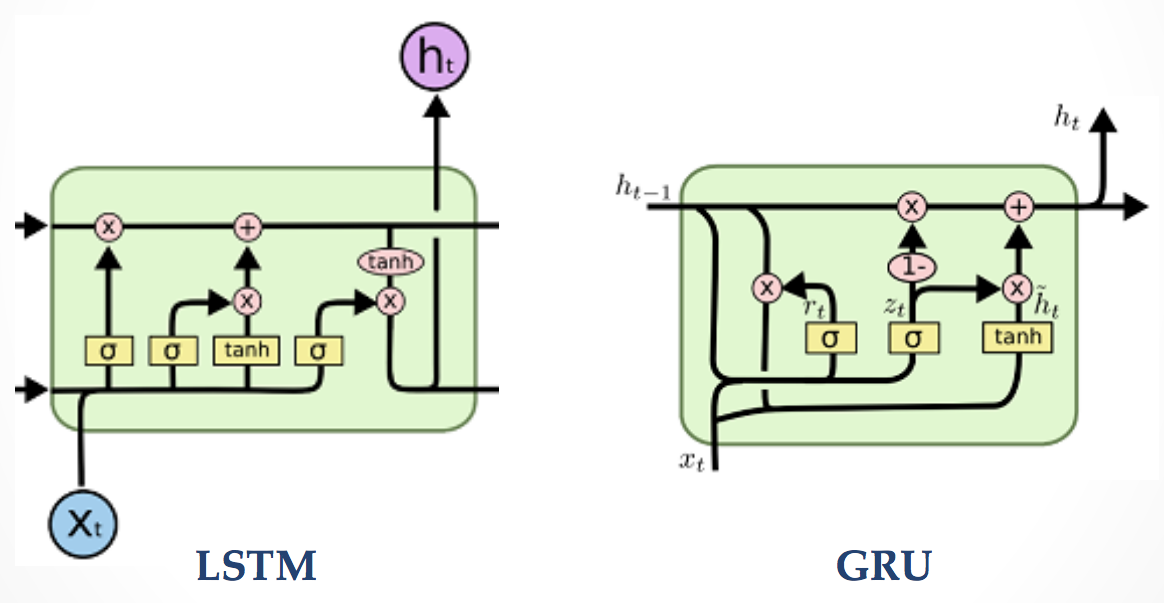

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class ModelRNN(nn.Module):
    
    def __init__(self, vocabulary, embedding_len=128, hidden_dim=512,):
        super().__init__()
        self._vocabulary = vocabulary
        self._embeddings = nn.Embedding( len(vocabulary), embedding_len )
        self._gru = nn.GRU( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True, num_layers=1, ) 
        self._linear = nn.Linear( hidden_dim, len(vocabulary) )

    def forward(self,x):
        o = self._embeddings(x)
        o,_ = self._gru(o) # обрабатываем входную последовательность
        o = o[:,-1]
        o = self._linear(o) # считаем выход сети
        o = F.log_softmax(o,dim=-1)
        return o
    
    def predict(self,x):
        return torch.argmax( self.forward(x), dim=-1 , keepdims=True)
    
    @property
    def vocabulary(self): return self._vocabulary

In [12]:
# x,t = ds[:2]
# display(x.shape,t.shape)
# display(len(ds.vocabulary))

# model = ModelRNN(vocabulary=ds.vocabulary)

# o = model.forward(x)
# display( o.shape )

# o = model.predict(x)
# display( o.shape )

# обучаем модель

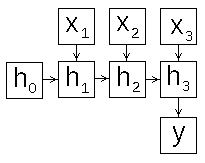

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

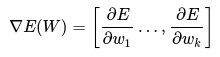


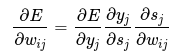

процедура обратного распространения ошибки

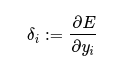

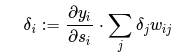

In [13]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [14]:
model = ModelRNN(vocabulary=ds.vocabulary,).to(device)

In [15]:
# ф-ция потери
# criterion =  nn.BCELoss()
criterion = nn.NLLLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

In [16]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [17]:
loss_history = [] # значения ф-ции потери

In [18]:
%%time

n_epoch = 32 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=len(ds)//5, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    if loss_history[-1]<1e-2: break

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 379 ms, sys: 42.5 ms, total: 422 ms
Wall time: 428 ms


Text(0.5, 1.0, 'min loss: 0.00907')

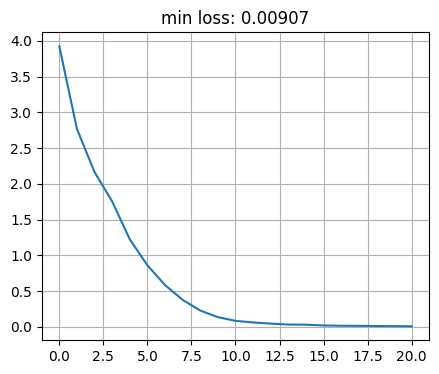

In [19]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [20]:
from sklearn.metrics import accuracy_score


for x,t in DataLoader(ds,len(ds)): break

with torch.set_grad_enabled(False): # генерируем следующий токен
    p = model.predict(x.to(device)).cpu().numpy() #.item()
        
t = t.numpy().reshape(-1,1)

display( accuracy_score(y_true=t, y_pred=p ) )

1.000

In [21]:
import pandas as pd

In [22]:
def decode(x,vocabulary):
    v = { n:w for w,n in  vocabulary.items() }
    return [
        ''.join([ v[c] for c in s ])
        for s in x
    ]

In [23]:
import pandas as pd

# декодируем слова
df = pd.DataFrame({
         'sequence': decode(x.numpy(),ds.vocabulary),
           'target': decode(t,ds.vocabulary),
         'predicted': decode(p,ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,"лышали? Говорят, таинств",е,е
1,таинственная история и.,.,.
2,тория и... и опять на ар,е,е
3,ть на арене Ставрогин...,,
4,рогин... Гм. Я бы спать,п,п
...,...,...,...
58,всё в буфете и наблюдаю,",",","
59,"наблюдаю, -- прошептал о",н,н
60,шептал он с видом винова,т,т
61,"м виноватого школьника,",в,в
